In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import lil_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

import pickle 

import time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from scipy.sparse import hstack
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm

In [2]:
from abc import abstractmethod

In [3]:
class SpecificTypeError(TypeError):
  def __init__(self, real_type: str, expected_type: str):
    message = f'{expected_type} expected instead of {real_type}'
    super().__init__(message)

In [4]:
class EmptyError(ValueError):
  def __init__(self, type_object: str):
    message = f'{type_object} is empty'
    super().__init__(message)

In [5]:
class Matrix:
  __matrix = lil_matrix

  def __init__(self, matrix: lil_matrix):
    if not isinstance(matrix, lil_matrix):
      raise SpecificTypeError(type(matrix).__name__, lil_matrix.__name__)
    self.__matrix = matrix

  def __getitem__(self, row: int) -> list:
    return self.__matrix.getrow(row).toarray()

In [6]:
class Ngrammer:

  @staticmethod
  def make_ngram(tokens: list, n: int) -> list:
    if n <= 0:
      raise EmptyError("n")
    ngrams = []
    for i in range(0, len(tokens) - n + 1):
        ngrams.append(' '.join(tokens[i:i + n]))

    return ngrams

In [7]:
class AbstractNgramModel:
  _n = -1
  _words = []
  _matrix = Matrix
  _rows = []
  _cols = []
  _rows_id = dict()
  _cols_id = dict()
  _ngrams = []

  @property
  def get_matrix(self) -> Matrix:
    return self._matrix

  @property
  def get_rows(self):
    return self._rows

  @property
  def get_cols(self):
    return self._cols

  @property
  def get_rows_id(self):
    return self._rows_id

  @property
  def get_cols_id(self):
    return self._cols_id

  @property
  def get_ngrams(self):
    return self._ngrams

  def __init__(self, n: int, words: list):
    if not isinstance(words, list):
      raise SpecificTypeError(type(words).__name__, list.__name__)
    self._n = n
    self._words = words

  def _make_ngrams(self, tokens: list, n: int):
    return Ngrammer.make_ngram(tokens, n)

  @abstractmethod
  def make_model(self):
    pass

In [8]:
class NgramModelCreator:
  __n = -1
  __words = []

  def __init__(self, n: int, words: list):
    if not isinstance(n, int):
      raise SpecificTypeError(type(n).__name__, int.__name__)
    if not isinstance(words, list):
      raise SpecificTypeError(type(words).__name__, list.__name__)
    if n <= 0:
      raise EmptyError("n")
    if len(words) == 0:
      raise EmptyError(type(words).__name__)
    self.__n = n
    self.__words = words

  @property
  def get_model(self) -> AbstractNgramModel:
    if self.__n == 1:
      return UnigramModel(self.__n, self.__words)
    else:
      return NgramModel(self.__n, self.__words)

In [9]:
class PerplexityMetric:
  __words = []
  __ngrams = []
  __n = -1

  def __init__(self, words: list, ngrams: list):
    if not isinstance(words, list):
      raise SpecificTypeError(type(words).__name__, list.__name__)
    if not isinstance(ngrams, list):
      raise SpecificTypeError(type(ngrams).__name__, list.__name__)
    self.__words = words
    self.__ngrams = ngrams
    self.__n = len(self.__ngrams)

  def __perplexity(self, probas) -> float:
    p = np.exp(np.sum(probas))
    N = len(probas)

    return p**(-1/N)

  def compute_perplexity(self) -> list:
    perplexities = []

    for word in self.__words:
      if len(word) <= self.__n-1:
        perplexities.append(np.mean(perplexities + [1]))
        continue

      prob = []
      
      for ngram in Ngrammer.make_ngram(word, n=self.__n):
          phrase = ngram.split()

          if ngram in self.__ngrams[-1]:
              if self.__n == 1:
                prob.append(np.log(self.__ngrams[0][ngram]/self.__ngrams[0][phrase[0]]))
              else:
                prob.append(np.log(self.__ngrams[-1][ngram]/self.__ngrams[self.__n-2][' '.join(phrase[:self.__n-1])]))
          else:
              prob.append(np.log(0.00001))
      
      perplexities.append(self.__perplexity(prob))

    return perplexities

In [10]:
class NgramModel(AbstractNgramModel):

  def __init__(self, n: int, words: list):
    AbstractNgramModel.__init__(self, n, words)

  def make_model(self):
    self._ngrams = [Counter() for i in range(self._n)]

    self._ngrams = self.__generate_ngrams_list(self._ngrams, self._n)

    self._rows = list(self._ngrams[-2])
    self._rows_id = {gram: i for i, gram in enumerate(self._rows)}
    self._cols = list(self._ngrams[0])
    self._cols_id = {word: i for i, word in enumerate(self._cols)}

    self._matrix = self.__fill_matrix(self._n)

  def __generate_ngrams_list(self, ngrams: list, n: int) -> list:
    for word in self._words:
      ngrams[0].update(word)
      for i in range(2, n+1):
        ngrams[i-1].update(self._make_ngrams(word, n=i))

    return ngrams

  def __fill_matrix(self, n: int) -> Matrix:
    all_matrix = lil_matrix((len(self._ngrams[-2]), 
                         len(self._ngrams[0])),)

    for ngram in self._ngrams[-1]:

        phrase = ngram.split()

        #print(phrase)

        all_matrix[self._rows_id[' '.join(phrase[:n-1])], self._cols_id[phrase[-1]]] =  (self._ngrams[n-1][ngram]/
                                                                        self._ngrams[n-2][' '.join(phrase[:n-1])] + 1)
    
    return Matrix(all_matrix)

In [11]:
class AbstractPreprocessingBuilder:

  _n = -1
  _result = None

  @property
  def result(self):
    return self._result

  @property
  def words(self):
    pass

  @words.setter
  def words(self, words):
    pass

  @property
  def n(self) -> int:
    return self._n

  @n.setter
  def n(self, value: int):
    if not isinstance(value, int):
      raise SpecificTypeError(type(value).__name__, int.__name__)
    self._n = value

  def __init__(self):
    self._result = None

  @abstractmethod
  def build(self):
    pass

In [12]:
class SeriePreprocessingBuilder(AbstractPreprocessingBuilder):

  __serie = None

  @property
  def words(self):
    return self.__serie

  @words.setter
  def words(self, words: pd.Series):
    if not isinstance(words, pd.Series):
      SpecificTypeError(type(words).__name__, pd.Series.__name__)
    self.__serie = words.copy()

  def build(self):
    self._result = self.__serie.apply(self.__convert_to_list()).apply(self.__replace_spaces()).apply(self.__add_pseudo_words())
  
  def __convert_to_list(self):
    return lambda x: [x] if not isinstance(x, list) else x
  
  def __replace_spaces(self):
    return lambda x: ['#' if letter in ['', ' '] else letter for letter in x]

  def __add_pseudo_words(self):
    return lambda x: ['<start>'] * (self._n - 1) + x + ['<end>']

In [13]:
class PreprocessingDirector:

  __builder = AbstractPreprocessingBuilder

  def __init__(self):
    self.__builder = None

  @property
  def builder(self) -> AbstractPreprocessingBuilder:
    return self.__builder
  
  @builder.setter
  def builder(self, builder: AbstractPreprocessingBuilder):
    self.__builder = builder

  def build(self, words: list, n: int):
    self.__builder.words = words
    self.__builder.n = n
    self.__builder.build()
    return self

In [14]:
class FilterDataFrame:

  __condition = ""
  __serie = None

  def __init__(self, condition: str, serie: pd.Series):
    if not isinstance(condition, str):
      raise SpecificTypeError(type(condition).__name__, str.__name__)
    if not isinstance(serie, pd.Series):
      raise SpecificTypeError(type(serie).__name__, pd.Series.__name__)
    self.__condition = condition
    self.__serie = serie

  def filter_result(self) -> pd.Series:
      conditions = {
        'EQUAL_1': self.__serie == 1,
        'EQUAL_0': self.__serie == 0,
        'IS_NULL': self.__serie.isnull(),
        'NOT_IS_NULL': ~self.__serie.isnull()
        }

      return conditions[self.__condition]

In [15]:
class DfPerplexityCreator:
    __df = pd.DataFrame

    def __init__(self, origin_df: pd.DataFrame, lang_column: str, language: str):
      self.__df = origin_df[origin_df[lang_column] == language]

    def get_perplexity_column(self, n: int, words_column: str, 
                              target_column: str, condition: str, 
                              director: PreprocessingDirector) -> pd.Series:
      mask = FilterDataFrame(condition, self.__df[target_column]).filter_result()
      words_serie = director.build(self.__df[mask][words_column].str.replace(' ', '#').str.split('-'), n).builder.result

      all_words = director.build(self.__df[words_column].str.replace(' ', '#').str.split('-'), n).builder.result

      model = NgramModelCreator(n, list(all_words)).get_model
      model.make_model()
      metric = PerplexityMetric(list(words_serie), model.get_ngrams)
      words_serie = pd.Series(metric.compute_perplexity(), index=words_serie.index)
      return words_serie

In [16]:
def make_df(df, conditions, words_column, director):
  perps_df = df[['glottocode', 'lemma', 'ipa', 'bor']]
  for i in range(2, 5):
    series = pd.Series()
    for language in perps_df['glottocode'].unique():
      print(language)
      df_creator = DfPerplexityCreator(perps_df, 'glottocode', language)
      series = series.append(df_creator.get_perplexity_column(i, words_column, 'bor', conditions[0], director))
      series = series.append(df_creator.get_perplexity_column(i, words_column, 'bor', conditions[1], director))
    perps_df[f'{i}_gram'] = series

  return perps_df

In [17]:
df = pd.read_csv('https://raw.githubusercontent.com/phon-dicts-project/comparative_andic_dictionary_database/master/andic_dicts.csv')

In [18]:
df.groupby('glottocode')['ipa'].count()

glottocode
akhv1239    14007
andi1255     6144
bagv1239    12706
botl1242    21483
cham1309     9721
ghod1238     7423
kara1474     6650
tind1238    12419
toki1238      218
Name: ipa, dtype: int64

### EDA

#### Data analysis

In [19]:
df.head(3)

,lang,id_word,id_meaning,id,lemma,ipa,morphology,annotator,pos,concepticon,...,glottocode,reference,comments,source,bor,borrowing_source_language,borrowing_source_transcription,borrowing_modified,borrowing_annotator,language
0,akhv1239,1,1,1,аба'далIи,a-b-'a-d-a-tɬː-i,NaN,Arseniy Averin,adj,everlasting,...,akhv1239,"Magomedova, Abdulayeva 2007",NaN,NaN,1.0,arab,abadi,1.0,Dasha Chistyakova,Akhvakh
1,NaN,2,1,2,а/б/а'жве,a-b-'a-ʒʷ-e,(-ролIи),Arseniy Averin,noun,sociability,...,akhv1239,"Magomedova, Abdulayeva 2007",NaN,NaN,NaN,NaN,NaN,1.0,NaN,Akhvakh
2,NaN,3,1,3,а/б/ажу'рулъIа,a-b-a-ʒ-'u-r-u-tɬ-a,"(абажвари', аба-жу'ва, абажва', абажве̄'гье, а...",Arseniy Averin,verb,NaN,...,akhv1239,"Magomedova, Abdulayeva 2007",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Akhvakh


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91076 entries, 0 to 91075
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   lang                            9 non-null      object 
 1   id_word                         91076 non-null  int64  
 2   id_meaning                      91076 non-null  int64  
 3   id                              91076 non-null  int64  
 4   lemma                           91076 non-null  object 
 5   ipa                             90771 non-null  object 
 6   morphology                      51615 non-null  object 
 7   annotator                       89230 non-null  object 
 8   pos                             39372 non-null  object 
 9   concepticon                     584 non-null    object 
 10  meaning_ru                      89541 non-null  object 
 11  definition                      84908 non-null  object 
 12  glottocode                      

In [21]:
df = df.drop_duplicates(['ipa', 'bor'])

In [22]:
df = df[~df['ipa'].isnull()]

In [23]:
df['bor'].value_counts()

1.0    7402
Name: bor, dtype: int64

In [24]:
df['bor'] = df['bor'].fillna(0)

In [25]:
df['bor'].value_counts()

0.0    47358
1.0     7402
Name: bor, dtype: int64

In [26]:
df.groupby(['glottocode', 'bor'])['ipa'].count()

glottocode  bor
akhv1239    0.0    6912
            1.0     928
andi1255    0.0    5159
            1.0     681
bagv1239    0.0    6307
            1.0    1266
botl1242    0.0    9364
            1.0    2514
cham1309    0.0    5992
            1.0     359
ghod1238    0.0    3529
            1.0     797
kara1474    0.0    4056
            1.0     393
tind1238    0.0    5845
            1.0     462
toki1238    0.0     194
            1.0       2
Name: ipa, dtype: int64

In [27]:
df = df[~df['glottocode'].str.contains('toki')]

#### Baseline

In [28]:
report = pd.DataFrame(columns=['language', 'macro f1', 'model'])

In [29]:
models = []

for language in df['glottocode'].unique():
  language_df = df[df['glottocode'] == language]

  vectorizer = TfidfVectorizer(ngram_range=(2, 4), token_pattern=r'\'?\w+')

  X = language_df['ipa'] 
  y = language_df[['bor']]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  X_train = vectorizer.fit_transform(X_train)

  clf = LogisticRegression(random_state=0).fit(X_train, y_train)

  preds = clf.predict(vectorizer.transform(X_test))

  models.append(clf)

  report = report.append(pd.DataFrame({'language': [language], 'macro f1': [f1_score(y_test, preds, average='macro')], 'model': ['baseline']}))

  print(language)
  print(classification_report(y_test, preds, zero_division=0, ))

akhv1239
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95      1391
         1.0       0.89      0.14      0.24       177

    accuracy                           0.90      1568
   macro avg       0.90      0.57      0.60      1568
weighted avg       0.90      0.90      0.87      1568

andi1255
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94      1035
         1.0       0.69      0.14      0.23       133

    accuracy                           0.89      1168
   macro avg       0.80      0.56      0.58      1168
weighted avg       0.88      0.89      0.86      1168

bagv1239
              precision    recall  f1-score   support

         0.0       0.86      0.99      0.92      1258
         1.0       0.77      0.22      0.34       257

    accuracy                           0.86      1515
   macro avg       0.81      0.60      0.63      1515
weighted avg       0.84      0.86      0.82    

### Model

#### Vectorizer hyperparameters selection

In [30]:
def fit_language_model(X_train, increase_bor_rate, decrease_bor_rate, n,):
  non_bor_words = X_train[X_train['bor'] == 0]['ipa'].str.split('-')
  bor_words = X_train[X_train['bor'] == 1]['ipa'].str.split('-')
  director = PreprocessingDirector()
  director.builder = SeriePreprocessingBuilder()
  builded_words = director.build(non_bor_words, n).builder.result
  bor_words = director.build(bor_words, n).builder.result
  model = NgramModelCreator(n, list(builded_words)).get_model
  model.make_model()

  all_words = X_train['ipa'].str.split('-')
  all_words = director.build(all_words, n).builder.result
  all_ngrams = [Ngrammer.make_ngram(word, n) for word in all_words]

  is_bors = []

  for word in all_ngrams:
    bor_rate = 0
    for ngram in word:
      if model.get_ngrams[n - 1][ngram] <= 2:
        bor_rate += increase_bor_rate
      else:
        bor_rate -= decrease_bor_rate
    is_bors.append(bor_rate / len(word))

  return is_bors

In [31]:
def compare_models(features, clfs, vectorizers, languages_model_params=None):
  comparison_table = {glottocode: [] for glottocode in features['glottocode'].unique()}

  for language in tqdm(features['glottocode'].unique()):
    language_features = features[features['glottocode'] == language]
    X = language_features.copy()
    y = language_features[['bor']]
    kf = StratifiedKFold(n_splits=5)

    for i in range(len(clfs)):
      scores = []
      for train_index, test_index in kf.split(X, y,):
        clf = clfs[i]
        vectorizer = vectorizers[i]
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train_vectorized = vectorizer.fit_transform(X_train['ipa'])

        if languages_model_params:
           X_train_vectorized = hstack((X_train_vectorized, np.asarray(fit_language_model(X_train, **languages_model_params[i])).reshape(-1, 1)))

        clf.fit(X_train_vectorized, y_train)

        X_test_vectorized = vectorizer.transform(X_test['ipa'])
        if languages_model_params:
          X_test_vectorized = hstack((X_test_vectorized, np.asarray(fit_language_model(X_test, **languages_model_params[i])).reshape(-1, 1)))

        preds = clf.predict(X_test_vectorized)

        scores.append(f1_score(y_test, preds, average='macro'))
      comparison_table[language].append(np.mean(scores))

  return comparison_table

In [32]:
compare_models(
    df, 
    [LogisticRegression(random_state=0), LogisticRegression(random_state=0)],
    [TfidfVectorizer(ngram_range=(2, 4), token_pattern=r'\'?\w+'), CountVectorizer(token_pattern=r'\'?\w+', ngram_range=(2, 4))]
)

100%|██████████| 8/8 [00:51<00:00,  6.47s/it]


{'akhv1239': [0.5292926153112136, 0.5974775039440132],
 'andi1255': [0.5663669615380714, 0.6113874017720122],
 'bagv1239': [0.5715482333674382, 0.6699905162513298],
 'botl1242': [0.6820124949727926, 0.7220885829566304],
 'cham1309': [0.4881946970843778, 0.5153601993711583],
 'ghod1238': [0.5568128768783078, 0.6563100993071137],
 'kara1474': [0.48197821357474246, 0.5856164882441657],
 'tind1238': [0.4980892205663913, 0.5636702101529639]}

In [33]:
#params = {'min_df':0.0004, 'max_df':100}
#CountVectorizer(token_pattern=r'\'?\w+', **kwargs)
def hyperparams_selection(features, params):
  comparison = []
  compared_params = []

  for param, values in params.items():
    for value in values:
      args = {param: value}
      vectorizers = []
      vectorizer_params = []
      vectorizers.append(CountVectorizer(token_pattern=r'\'?\w+', ngram_range=(2, 4), **args))
      vectorizer_params.append(args)
      try:
        comparison.append(compare_models(features, [LogisticRegression(random_state=0)]*len(vectorizers), vectorizers))
      except:
        comparison.append({'error': [0]})
      compared_params.append(vectorizer_params)
  return comparison, compared_params

In [34]:
params = {'min_df': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001], 'max_df': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}
comparisons, comparison_params = hyperparams_selection(df, params)

  0%|          | 0/8 [00:00<?, ?it/s]


In [35]:
means = [np.mean([values for values in comparison.values() for value in values]) for comparison in comparisons]

In [36]:
np.argmax(means[:len(means) // len(params)]), np.argmax(means[len(means) // len(params):])

(3, 1)

In [37]:
def condition(w):
    condition_passed = abs(w)>0.9
    return condition_passed

In [38]:
for language in df['glottocode'].unique():
  language_df = df[df['glottocode'] == language]

  vectorizer = CountVectorizer(token_pattern=r'\'?\w+', ngram_range=(2, 4), min_df=0.001, max_df=0.1)

  X = language_df['ipa']
  y = language_df[['bor']]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  X_train_transformed = vectorizer.fit_transform(X_train)

  clf = LogisticRegression().fit(X_train_transformed, y_train)

  feat_name2weight = dict(zip(vectorizer.get_feature_names(), clf.coef_[0]))

  important_features = {fname: weight for fname, weight in feat_name2weight.items() if weight>0 and condition(weight)}

  ngram_features = X_train.str.replace('-', ' ').map(lambda x: (sum(feature in x for feature in important_features.keys()) * 10 - len(x) * 4) / len(x)).values[:, None]

  X_train_transformed = hstack((X_train_transformed, ngram_features))

  clf = LogisticRegression(random_state=0).fit(X_train_transformed, y_train)

  X_test_transformed = vectorizer.transform(X_test)

  ngram_features = X_test.str.replace('-', ' ').map(lambda x: (sum(feature in x for feature in important_features.keys()) * 10 - len(x) * 4) / len(x)).values[:, None]

  X_test_transformed = hstack((X_test_transformed, ngram_features))

  preds = clf.predict(X_test_transformed)

  report = report.append(pd.DataFrame({'language': [language], 'macro f1': [f1_score(y_test, preds, average='macro')], 'model': ['countV logit']}))

  print(language)
  print(classification_report(y_test, preds, zero_division=0, ))

akhv1239
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      1391
         1.0       0.64      0.46      0.54       177

    accuracy                           0.91      1568
   macro avg       0.79      0.72      0.74      1568
weighted avg       0.90      0.91      0.90      1568

andi1255
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94      1035
         1.0       0.57      0.42      0.48       133

    accuracy                           0.90      1168
   macro avg       0.75      0.69      0.71      1168
weighted avg       0.89      0.90      0.89      1168

bagv1239
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93      1258
         1.0       0.71      0.46      0.56       257

    accuracy                           0.88      1515
   macro avg       0.80      0.71      0.74      1515
weighted avg       0.87      0.88      0.87    

In [39]:
director = PreprocessingDirector()
director.builder = SeriePreprocessingBuilder()
perps_df_ipa = make_df(df, ['EQUAL_1', 'EQUAL_0'], 'ipa', director)

akhv1239
andi1255
bagv1239
botl1242
cham1309
ghod1238
kara1474
tind1238
akhv1239
andi1255
bagv1239
botl1242
cham1309
ghod1238
kara1474
tind1238
akhv1239
andi1255
bagv1239
botl1242
cham1309
ghod1238
kara1474
tind1238


In [40]:
columns = [column for column in perps_df_ipa.columns if 'gram' in column]

for column in columns:
  perps_df_ipa[f'{column}_log'] = np.log(perps_df_ipa[column])

In [41]:
violin_ipa = perps_df_ipa.copy()

min_outliers = violin_ipa.groupby(['glottocode'])['2_gram', '3_gram', '4_gram'].quantile(.05).to_dict()
max_outliers = violin_ipa.groupby(['glottocode'])['2_gram', '3_gram', '4_gram'].quantile(.95).to_dict()

violin_ipa = violin_ipa[violin_ipa.apply(lambda x: (x['2_gram'] > min_outliers['2_gram'][x['glottocode']]) & (x['2_gram'] < max_outliers['2_gram'][x['glottocode']]), axis=1)]
violin_ipa = violin_ipa[violin_ipa.apply(lambda x: (x['3_gram'] > min_outliers['3_gram'][x['glottocode']]) & (x['3_gram'] < max_outliers['3_gram'][x['glottocode']]), axis=1)]
violin_ipa = violin_ipa[violin_ipa.apply(lambda x: (x['4_gram'] > min_outliers['4_gram'][x['glottocode']]) & (x['4_gram'] < max_outliers['4_gram'][x['glottocode']]), axis=1)]

violin_ipa = violin_ipa.melt(id_vars=['glottocode', 'bor'], value_vars=['2_gram', '3_gram', '4_gram'], value_name='perplexity', var_name='n_gram')

violin_ipa = violin_ipa.rename(columns={'bor': 'is borrowing', 'n_gram': 'n-gram'})

bool_encoder = {1: 'Yes', 0: 'No'}
n_gram_encoder = {'2_gram': '2-gram', '3_gram': '3-gram', '4_gram': '4-gram'}
violin_ipa['is borrowing'] = violin_ipa['is borrowing'].replace(bool_encoder)
violin_ipa['n-gram'] = violin_ipa['n-gram'].replace(n_gram_encoder)

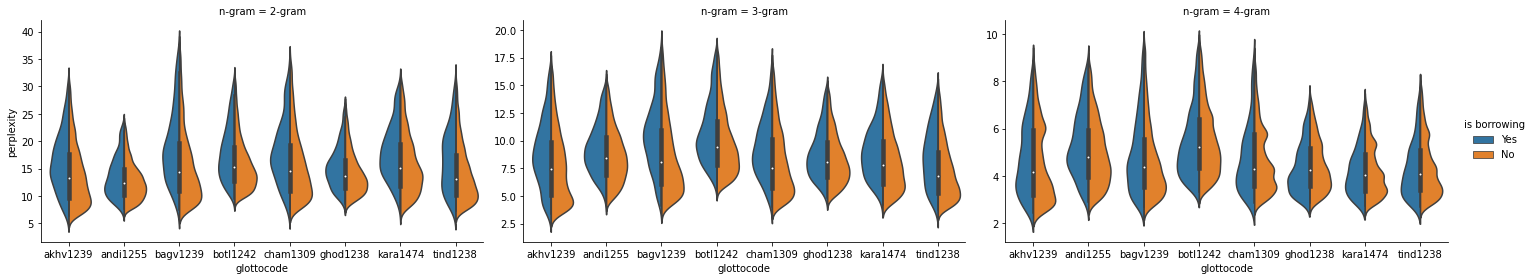

In [42]:
g = sns.catplot(x="glottocode", y="perplexity",
                hue="is borrowing", col="n-gram",
                data=violin_ipa, kind="violin", 
                split=True,
                height=4,
                #weight=20, 
                aspect=1.7,
                sharey=False
                );

In [43]:
df['ipa'] = df['ipa'].str.replace(' ', '#')

In [44]:
means = compare_models(
    df, 
    [LogisticRegression(random_state=0), ] * 5,
    [CountVectorizer(token_pattern=r'\'?\w+', ngram_range=(2, 4), min_df=0.001, max_df=0.1), ] * 5,
    [{'increase_bor_rate': 1, 'decrease_bor_rate': 1, 'n': 3},
     {'increase_bor_rate': 3, 'decrease_bor_rate': 5, 'n': 3},
     {'increase_bor_rate': 5, 'decrease_bor_rate': 10, 'n': 3},
     {'increase_bor_rate': 5, 'decrease_bor_rate': 3, 'n': 3},
     {'increase_bor_rate': 10, 'decrease_bor_rate': 5, 'n': 3}]
)

100%|██████████| 8/8 [02:01<00:00, 15.23s/it]


In [45]:
np.argmax(np.mean([m for m in means.values()], 1))

3

In [46]:
lm_params = {'increase_bor_rate': 5, 'decrease_bor_rate': 3, 'n': 3}

In [47]:
from sklearn.model_selection import KFold, StratifiedKFold

cols = ['3_gram']

for language in df['glottocode'].unique():
  language_df = df[df['glottocode'] == language]

  vectorizer = CountVectorizer(token_pattern=r'\'?\w+', 
                            ngram_range=(2, 4), min_df=0.001, max_df=0.1)

  X_train, X_test, y_train, y_test = train_test_split(language_df, language_df[['bor']], test_size=0.2, random_state=42)

  X = vectorizer.fit_transform(X_train['ipa'])

  X = hstack((X, np.asarray(fit_language_model(X_train, **lm_params)).reshape(-1, 1)))

  clf = LogisticRegression(random_state=0).fit(X, y_train)

  X_test_transformed = vectorizer.transform(X_test['ipa'])

  X_test_transformed = hstack((X_test_transformed, np.asarray(fit_language_model(X_test, **lm_params)).reshape(-1, 1)))

  preds = clf.predict(X_test_transformed)

  report = report.append(pd.DataFrame({'language': [language], 'macro f1': [f1_score(y_test, preds, average='macro')], 'model': ['count logit lm']}))

  print(language)
  print(classification_report(y_test, preds, zero_division=0))

akhv1239
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94      1391
         1.0       0.55      0.71      0.62       177

    accuracy                           0.90      1568
   macro avg       0.75      0.82      0.78      1568
weighted avg       0.91      0.90      0.91      1568

andi1255
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94      1035
         1.0       0.53      0.62      0.57       133

    accuracy                           0.89      1168
   macro avg       0.74      0.78      0.76      1168
weighted avg       0.90      0.89      0.90      1168

bagv1239
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92      1258
         1.0       0.61      0.68      0.65       257

    accuracy                           0.87      1515
   macro avg       0.77      0.80      0.78      1515
weighted avg       0.88      0.87      0.88    

In [48]:
from sklearn.model_selection import KFold, StratifiedKFold

cols = ['3_gram']

for language in df['glottocode'].unique():
  language_df = df[df['glottocode'] == language]

  vectorizer = CountVectorizer(token_pattern=r'\'?\w+', 
                            ngram_range=(2, 4), min_df=0.001, max_df=0.1)

  X_train, X_test, y_train, y_test = train_test_split(language_df, language_df[['bor']], test_size=0.2, random_state=42)

  X = vectorizer.fit_transform(X_train['ipa'])

  clf = LogisticRegression().fit(X, y_train)

  feat_name2weight = dict(zip(vectorizer.get_feature_names(), clf.coef_[0]))

  important_features = {fname: weight for fname, weight in feat_name2weight.items() if weight>0 and condition(weight)}

  ngram_features = X_train['ipa'].str.replace('-', ' ').map(lambda x: (sum(feature in x for feature in important_features.keys()) * 10 - len(x) * 4) / len(x)).values[:, None]

  X = hstack((X, ngram_features))

  X = hstack((X, np.asarray(fit_language_model(X_train, **lm_params)).reshape(-1, 1)))

  clf = LogisticRegression(random_state=0).fit(X, y_train)

  X_test_transformed = vectorizer.transform(X_test['ipa'])

  ngram_features = X_test['ipa'].str.replace('-', ' ').map(lambda x: (sum(feature in x for feature in important_features.keys()) * 10 - len(x) * 4) / len(x)).values[:, None]

  X_test_transformed = hstack((X_test_transformed, ngram_features))

  X_test_transformed = hstack((X_test_transformed, np.asarray(fit_language_model(X_test, **lm_params)).reshape(-1, 1)))

  preds = clf.predict(X_test_transformed)

  report = report.append(pd.DataFrame({'language': [language], 'macro f1': [f1_score(y_test, preds, average='macro')], 'model': ['count logit lm feat']}))

  print(language)
  print(classification_report(y_test, preds, zero_division=0))

akhv1239
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94      1391
         1.0       0.54      0.74      0.63       177

    accuracy                           0.90      1568
   macro avg       0.75      0.83      0.78      1568
weighted avg       0.92      0.90      0.91      1568

andi1255
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.93      1035
         1.0       0.49      0.60      0.54       133

    accuracy                           0.88      1168
   macro avg       0.72      0.76      0.74      1168
weighted avg       0.90      0.88      0.89      1168

bagv1239
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92      1258
         1.0       0.61      0.74      0.67       257

    accuracy                           0.88      1515
   macro avg       0.78      0.82      0.80      1515
weighted avg       0.89      0.88      0.88    

In [49]:
pd.pivot_table(report, values='macro f1', index='model', columns=['language']).reindex(['baseline', 'countV logit', 'count logit lm', 'count logit lm feat'])

language,akhv1239,andi1255,bagv1239,botl1242,cham1309,ghod1238,kara1474,tind1238
model,,,,,,,,
baseline,0.595510,0.584958,0.629327,0.781564,0.495935,0.647212,0.494914,0.539122
countV logit,0.743950,0.712862,0.744107,0.845130,0.700626,0.792110,0.689029,0.682383
count logit lm,0.780231,0.757153,0.784913,0.817889,0.772578,0.807746,0.712589,0.724900
count logit lm feat,0.783757,0.738114,0.797135,0.825383,0.777901,0.814534,0.714519,0.725561


In [50]:
class IpaClassifier():
  clf = None
  __model = None
  __important_features = None
  __vectorizer = None

  def fit(self, X, y):
    X = X.copy()

    n = lm_params['n']

    self.__vectorizer = CountVectorizer(token_pattern=r'\'?\w+', 
                          ngram_range=(2, 4), min_df=0.001, max_df=0.1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X = self.__vectorizer.fit_transform(X_train['ipa'])

    clf = LogisticRegression().fit(X, y_train)

    feat_name2weight = dict(zip(self.__vectorizer.get_feature_names(), clf.coef_[0]))

    self.__important_features = {fname: weight for fname, weight in feat_name2weight.items() if weight>0 and condition(weight)}

    ngram_features = X_train['ipa'].str.replace('-', ' ').map(lambda x: (sum(feature in x for feature in self.__important_features.keys()) * 10 - len(x) * 4) / len(x)).values[:, None]

    X = hstack((X, ngram_features))

    non_bor_words = X_train[X_train['bor'] == 0]['ipa'].str.split('-')
    bor_words = X_train[X_train['bor'] == 1]['ipa'].str.split('-')
    director = PreprocessingDirector()
    director.builder = SeriePreprocessingBuilder()
    builded_words = director.build(non_bor_words, n).builder.result
    bor_words = director.build(bor_words, n).builder.result
    self.__model = NgramModelCreator(n, list(builded_words)).get_model
    self.__model.make_model()

    all_words = X_train['ipa'].str.split('-')
    all_words = director.build(all_words, n).builder.result
    all_ngrams = [Ngrammer.make_ngram(word, n) for word in all_words]

    is_bors = []

    for word in all_ngrams:
      bor_rate = 0
      for ngram in word:
        if self.__model.get_ngrams[n - 1][ngram] <= 2:
          bor_rate += lm_params['increase_bor_rate']
        else:
          bor_rate -= lm_params['decrease_bor_rate']
      is_bors.append(bor_rate / len(word))

    X = hstack((X, np.asarray(is_bors).reshape(-1, 1)))

    self.clf = LogisticRegression(random_state=0).fit(X, y_train)

    return self

  def predict(self, X):
    X_transformed = self.__vectorizer.transform(X['ipa'])

    ngram_features = X['ipa'].str.replace('-', ' ').map(lambda x: (sum(feature in x for feature in self.__important_features.keys()) * 10 - len(x) * 4) / len(x)).values[:, None]

    X_transformed = hstack((X_transformed, ngram_features))

    all_words = X['ipa'].str.split('-')
    all_words = director.build(all_words, lm_params['n']).builder.result
    all_ngrams = [Ngrammer.make_ngram(word, lm_params['n']) for word in all_words]

    is_bors = []

    for word in all_ngrams:
      bor_rate = 0
      for ngram in word:
        if self.__model.get_ngrams[lm_params['n'] - 1][ngram] <= 2:
          bor_rate += lm_params['increase_bor_rate']
        else:
          bor_rate -= lm_params['decrease_bor_rate']
      is_bors.append(bor_rate / len(word))

    X_transformed = hstack((X_transformed, np.asarray(is_bors).reshape(-1, 1)))

    return self.clf.predict(X_transformed)

In [51]:
class LemmaClassifier():
  clf = None
  __model = None
  __important_features = None
  __vectorizer = None

  def fit(self, X, y):
    X = X.copy()

    self.__vectorizer = CountVectorizer(analyzer='char', 
                            ngram_range=(2, 4), max_df=1.0, min_df=0.001)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X = self.__vectorizer.fit_transform(X_train['lemma'])
    #y = language_df['bor']

    clf = LogisticRegression(random_state=0).fit(X, y_train)

    feat_name2weight = dict(zip(self.__vectorizer.get_feature_names(), clf.coef_[0]))

    self.__important_features = {fname: weight for fname, weight in feat_name2weight.items() if weight<0 and condition(weight)}

    ngram_features = X_train['lemma'].str.replace('-', ' ').map(lambda x: (sum(feature in x for feature in self.__important_features.keys()) * 10 - len(x) * 4) / len(x)).values[:, None]

    X = hstack((X, ngram_features))

    n = 3
    non_bor_words = X_train[(X_train['bor'] == 0)]['lemma'].str.lower().str.split('')
    bor_words = X_train[(X_train['bor'] == 1)]['lemma'].str.lower().str.split('')
    director = PreprocessingDirector()
    director.builder = SeriePreprocessingBuilder()
    builded_words = director.build(non_bor_words, n).builder.result
    bor_words = director.build(bor_words, n).builder.result
    self.__model = NgramModelCreator(n, list(builded_words)).get_model
    self.__model.make_model()

    all_words = X_train['lemma'].str.lower().str.split('')
    all_words = director.build(all_words, n).builder.result
    all_ngrams = [Ngrammer.make_ngram(word, n) for word in all_words]

    is_bors = []

    for word in all_ngrams:
      bor_rate = 0
      for ngram in word:
        if self.__model.get_ngrams[n - 1][ngram] <= 2:
          bor_rate += lm_params['increase_bor_rate']
        else:
          bor_rate -= lm_params['decrease_bor_rate']
      is_bors.append(bor_rate / len(word))

    X = hstack((X, np.asarray(is_bors).reshape(-1, 1)))

    self.clf = LogisticRegression(random_state=0).fit(X, y_train)

    return self

  def predict(self, X):
    n = 3

    X_transformed = self.__vectorizer.transform(X['lemma'])

    ngram_features = X['lemma'].str.replace('-', ' ').map(lambda x: (sum(feature in x for feature in self.__important_features.keys()) * 10 - len(x) * 4) / len(x)).values[:, None]

    X_transformed = hstack((X_transformed, ngram_features))

    all_words = X['lemma'].str.lower().str.split('')
    all_words = director.build(all_words, n).builder.result
    all_ngrams = [Ngrammer.make_ngram(word, n) for word in all_words]

    is_bors = []

    for word in all_ngrams:
      bor_rate = 0
      for ngram in word:
        if self.__model.get_ngrams[n - 1][ngram] <= 2:
          bor_rate += lm_params['increase_bor_rate']
        else:
          bor_rate -= lm_params['decrease_bor_rate']
      is_bors.append(bor_rate / len(word))

    X_transformed = hstack((X_transformed, np.asarray(is_bors).reshape(-1, 1)))

    return self.clf.predict(X_transformed)

In [52]:
models = {}

for language in df['glottocode'].unique():
  language_df = df[df['glottocode'] == language]

  model = IpaClassifier()
  models[language] = model.fit(language_df, language_df['bor'])

In [53]:
import random

a = ord('а')
chrs = ''.join([chr(i) for i in range(a, a + 6)] + [chr(a + 33)] + [chr(i) for i in range(a + 6, a + 32)]) + ''.join([str(number) for number in range(10)])

print(''.join(random.choices(chrs, k=random.randint(3, 10))))

чх2ьё7ст


In [54]:
def test_lemma(models):
  means = []
  n = 100

  for i in range(n):
    random_words = [''.join(random.choices(chrs, k=random.randint(3, 10))) for i in range(n)]

    test = pd.DataFrame(data={
        'lemma': random_words,
        #'ipa': ['iː-t', 's-e-ɪ-m', 'ɪ-nˈ-v-ɛ-s-t']
    })

    preds = []
    for language, model in models.items():
      preds.append((models[language].predict(test) == 1).sum())

    means.append(np.mean(preds) / n)

  return np.mean(means), np.std(means)

In [55]:
def test_ipa(models, words):
  test = pd.DataFrame(data={
        'ipa': words
    })

  preds = []
  for language, model in models.items():
    preds.append((models[language].predict(test) == 1).sum())

  return np.mean(preds) / len(words)

In [56]:
test_ipa(models, ['ˈɑ-k-ə-n-ɝ', 'ˈɑ-b-ɝ-ɡ', 'əˈ-b-e-ɪ-t-m-ə-n-t-s', 'əˈ-b-a-ʊ-n-d', 'ˈɫ-a-ɪ-n-ɝ', 'ˈɫ-ɪ-p-s', 'ˈɫ-ɔ-f-t', 'ˈɫ-ə-v-d', 'ˈɫ-u-b', 'ˈɫ-ɪ-ɹ-ɪ-k-s'])

0.5375

In [57]:
from sklearn.model_selection import KFold, StratifiedKFold

cols = ['3_gram']

for language in df['glottocode'].unique():
  language_df = df[df['glottocode'] == language]
  
  vectorizer = CountVectorizer(analyzer='char', 
                            ngram_range=(2, 4), max_df=1.0, min_df=0.001)

  X_train, X_test, y_train, y_test = train_test_split(language_df, language_df[['bor']], test_size=0.2, random_state=42)

  X = vectorizer.fit_transform(X_train['lemma'])
  y = language_df['bor']

  clf = LogisticRegression(random_state=0).fit(X, y_train)

  feat_name2weight = dict(zip(vectorizer.get_feature_names(), clf.coef_[0]))

  important_features = {fname: weight for fname, weight in feat_name2weight.items() if weight<0 and condition(weight)}

  ngram_features = X_train['lemma'].str.replace('-', ' ').map(lambda x: (sum(feature in x for feature in important_features.keys()) * 10 - len(x) * 4) / len(x)).values[:, None]

  X = hstack((X, ngram_features))

  n = 3
  non_bor_words = X_train[(X_train['bor'] == 0)]['lemma'].str.lower().str.split('')
  bor_words = X_train[(X_train['bor'] == 1)]['lemma'].str.lower().str.split('')
  director = PreprocessingDirector()
  director.builder = SeriePreprocessingBuilder()
  builded_words = director.build(non_bor_words, n).builder.result
  bor_words = director.build(bor_words, n).builder.result
  model = NgramModelCreator(n, list(builded_words)).get_model
  model.make_model()

  all_words = X_train['lemma'].str.lower().str.split('')
  all_words = director.build(all_words, n).builder.result
  all_ngrams = [Ngrammer.make_ngram(word, n) for word in all_words]

  is_bors = []

  for word in all_ngrams:
    bor_rate = 0
    for ngram in word:
      if model.get_ngrams[n - 1][ngram] <= 2:
        bor_rate += lm_params['increase_bor_rate']
      else:
        bor_rate -= lm_params['decrease_bor_rate']
    is_bors.append(bor_rate / len(word))

  X = hstack((X, np.asarray(is_bors).reshape(-1, 1)))

  clf = LogisticRegression(random_state=0).fit(X, y_train)

  X_test_transformed = vectorizer.transform(X_test['lemma'])

  ngram_features = X_test['lemma'].str.replace('-', ' ').map(lambda x: (sum(feature in x for feature in important_features.keys()) * 10 - len(x) * 4) / len(x)).values[:, None]

  X_test_transformed = hstack((X_test_transformed, ngram_features))

  # n = 3
  # non_bor_words = X_test[(X_test['bor'] == 0)]['lemma'].str.lower().str.split('')
  # bor_words = X_test[(X_test['bor'] == 1)]['lemma'].str.lower().str.split('')
  # director = PreprocessingDirector()
  # director.builder = SeriePreprocessingBuilder()
  # builded_words = director.build(non_bor_words, n).builder.result
  # bor_words = director.build(bor_words, n).builder.result
  # model = NgramModelCreator(n, list(builded_words)).get_model
  # model.make_model()

  all_words = X_test['lemma'].str.lower().str.split('')
  all_words = director.build(all_words, n).builder.result
  all_ngrams = [Ngrammer.make_ngram(word, n) for word in all_words]

  is_bors = []

  for word in all_ngrams:
    bor_rate = 0
    for ngram in word:
      if model.get_ngrams[n - 1][ngram] <= 2:
        bor_rate += lm_params['increase_bor_rate']
      else:
        bor_rate -= lm_params['decrease_bor_rate']
    is_bors.append(bor_rate / len(word))

  X_test_transformed = hstack((X_test_transformed, np.asarray(is_bors).reshape(-1, 1)))

  preds = clf.predict(X_test_transformed)

  report = report.append(pd.DataFrame({'language': [language], 'macro f1': [f1_score(y_test, preds, average='macro')], 'model': ['count logit lm feat lemma']}))

  print(language)
  print(classification_report(y_test, preds, zero_division=0))

akhv1239
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96      1391
         1.0       0.70      0.54      0.61       177

    accuracy                           0.92      1568
   macro avg       0.82      0.75      0.78      1568
weighted avg       0.92      0.92      0.92      1568

andi1255
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95      1035
         1.0       0.62      0.46      0.53       133

    accuracy                           0.91      1168
   macro avg       0.77      0.71      0.74      1168
weighted avg       0.90      0.91      0.90      1168

bagv1239
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.94      1258
         1.0       0.72      0.61      0.66       257

    accuracy                           0.89      1515
   macro avg       0.82      0.78      0.80      1515
weighted avg       0.89      0.89      0.89    